# Caravan war screenshot unit card identification
```
This is a personal project to understand and improve my knowledge/tactics in the game Caravan War.
Copyright (C) 2019  Kasonnara <wins@kasonnara.fr>

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.
```

This experiment aim at automatically identifying unit cards on screenshots of the game

In [1]:
import math

import matplotlib.pyplot as plt
import numpy
import PIL.Image

import cv2

## Load some screenshots

In [2]:
screen_gate = PIL.Image.open("../img/screenshots/Screenshot_2020-04-26-16-31-59-237_com.hikergames.caravanwar.jpg")
screen_camp = PIL.Image.open("../img/screenshots/Screenshot_2020-04-24-22-13-51-514_com.hikergames.caravanwar.jpg")
screen_camp_2 = PIL.Image.open("../img/screenshots/Screenshot_2020-04-25-21-13-54-037_com.hikergames.caravanwar.jpg")
screen_fight= PIL.Image.open("../img/screenshots/Screenshot_2020-04-24-22-20-34-173_com.hikergames.caravanwar.jpg")

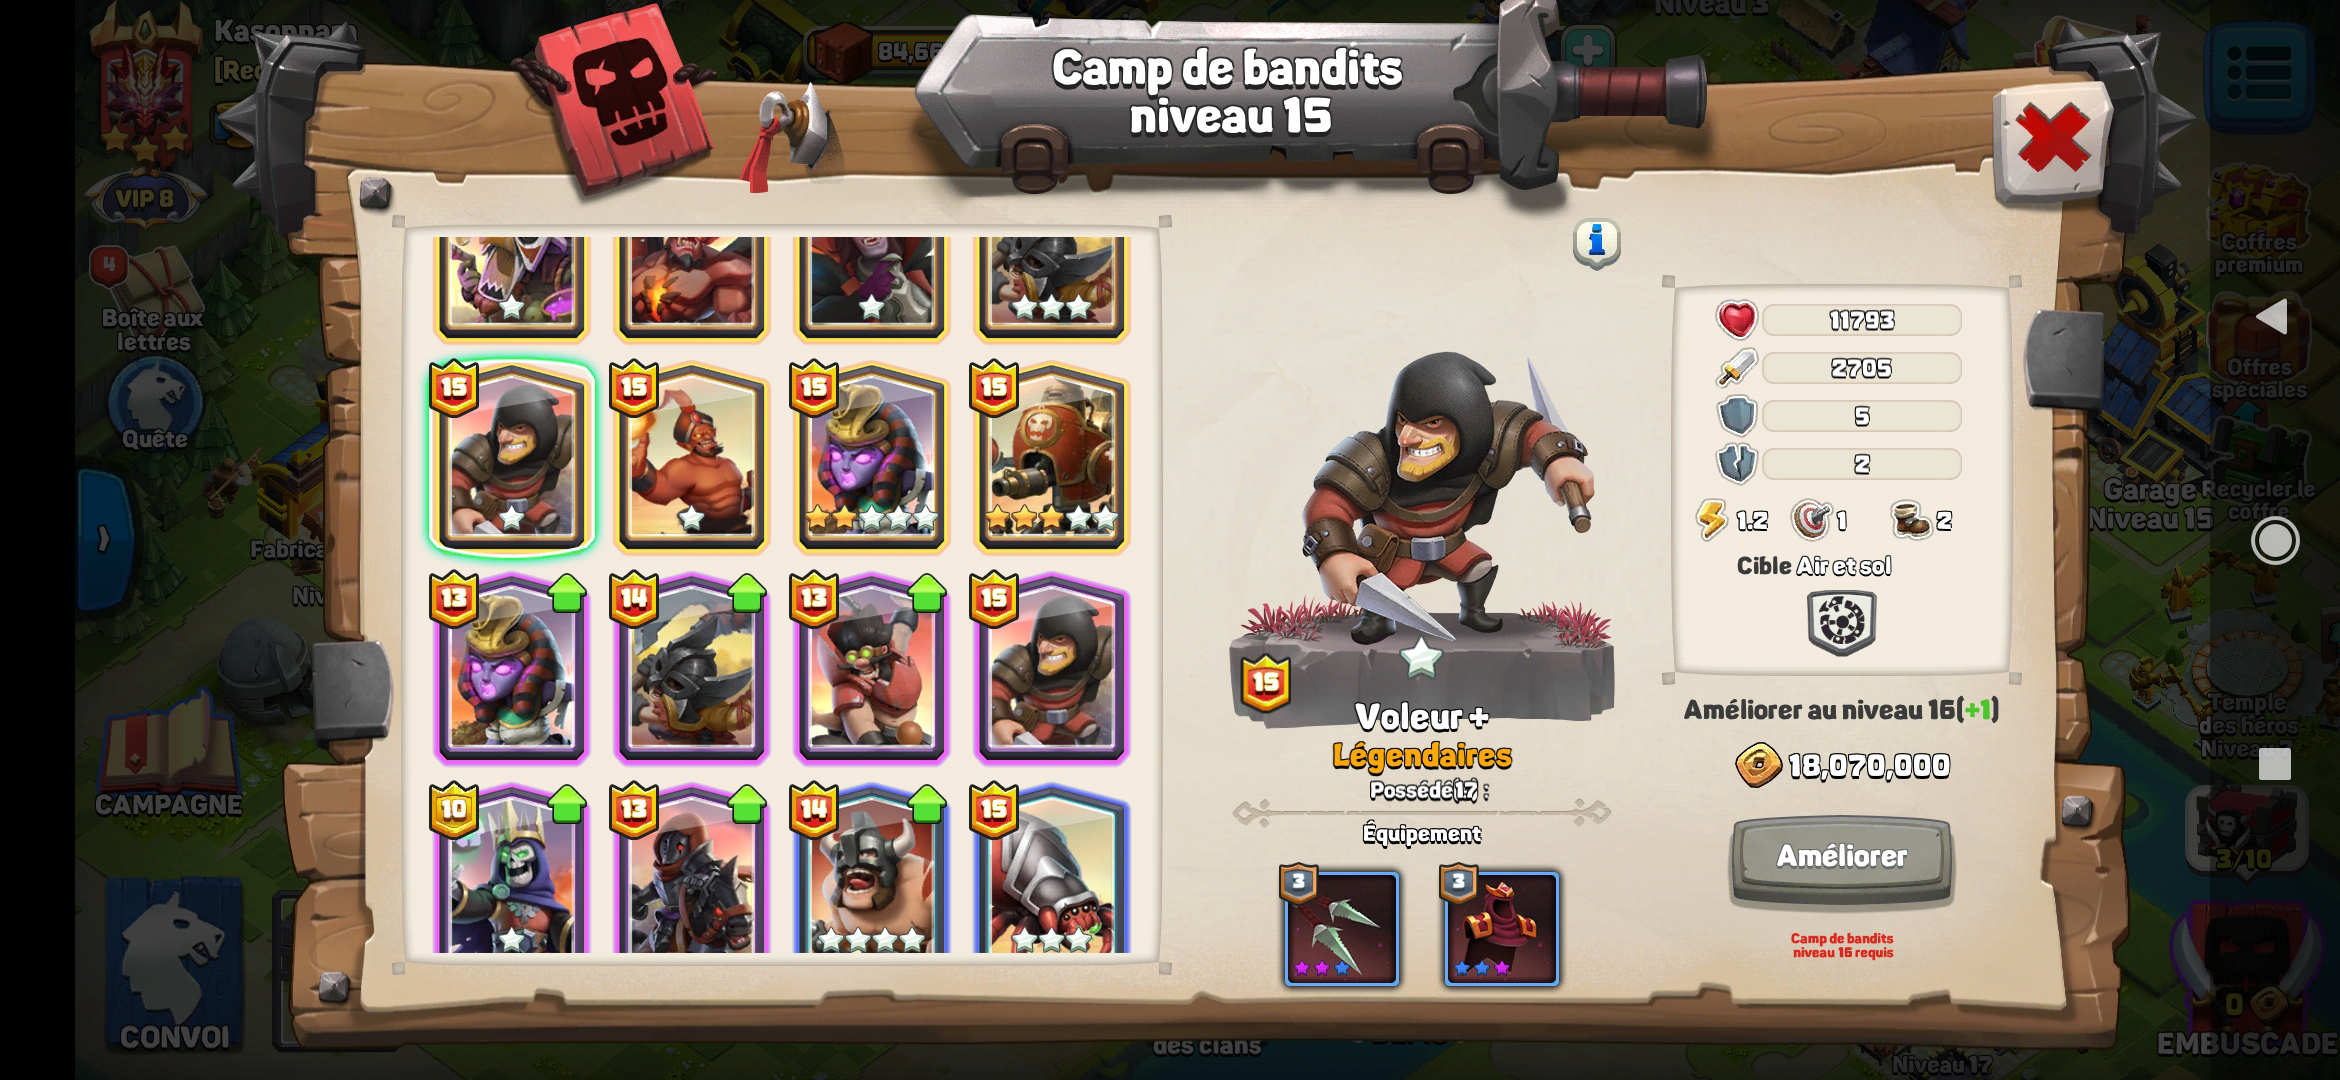

In [3]:
screen_camp

# First Attempt

## Load bandit border

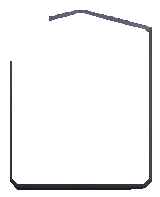

In [4]:
bandit_border = PIL.Image.open("../img/cards/bandit_border.png")
# TODO remove top right corner where the upgrade arrow icon can overlap 
# as well as somme pixel on the bottom where the stars can overlap
bandit_border

In [5]:
width, height = bandit_border.size
vertical_crop_offset = 35

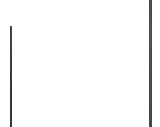

In [6]:
universal_border = bandit_border.crop((0, vertical_crop_offset, width, height-vertical_crop_offset))
universal_border

Remove the alpha channel and generate an mask out of it

In [7]:
#numpy.array(bandit_border) < 128

In [8]:
def extract_mask(rgba_image: PIL.Image):
    rgba_array = numpy.array(rgba_image)
    rgb_array = rgba_array[:,:,:3]
    
    mask = numpy.zeros(rgb_array.shape).astype(int)
    mask[rgba_array[:,:,3]>128] = numpy.array([255,255,255])
    return numpy.uint8(rgb_array), numpy.uint8(mask)

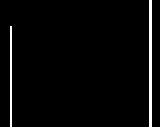

In [9]:
border_rgb, border_mask = extract_mask(universal_border)

#bandit_border_mask
PIL.Image.fromarray(border_mask)
#PIL.Image.fromarray(bandit_border_rgb)

## Detect card border using OpenCV

### Configuration

In [10]:
PREPROCESS_TO_GRAY = False
PREPROCESS_EDGE_DETECTION = False

PREPROCESS_DO_CROP = False
PREPROCESS_CROP_SIZE = 35

MATCHING_METHOD = cv2.TM_CCORR_NORMED
# MATCHING_METHOD = cv2.TM_SQDIFF

THRESHOLD = (0.997 if PREPROCESS_DO_CROP else 0.98)if MATCHING_METHOD is cv2.TM_CCORR_NORMED else 700



In [11]:

def preprocess(target: PIL.Image, template: PIL.Image):
    template = template.copy()
    if PREPROCESS_DO_CROP:
        # remove top and bottom of the template
        template_width, template_height = template.size
        tempalte_vertical_crop_offset = PREPROCESS_CROP_SIZE
        template = template.crop((0, PREPROCESS_CROP_SIZE, width, height - PREPROCESS_CROP_SIZE))
    else:
        template_width, template_height = template.size
        tempalte_vertical_crop_offset = 0
    
    # extract the alpha canal of the template and convert everything to numpy array compatible with opencv
    template, mask = extract_mask(template)
    target = numpy.uint8(target)
    
    ### Optionaly convert to grayscale and apply edge detection
    # Usually this improve result, but here as our image is very thin, this is not sure so I made it optional.
    if PREPROCESS_TO_GRAY:
        template = cv2.cvtColor(template, cv2.COLOR_RGB2GRAY)
        target = cv2.cvtColor(image_to_analyse, cv2.COLOR_RGB2GRAY)
        mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    
    if PREPROCESS_EDGE_DETECTION:
        template = cv2.Canny(template, 50, 200)
        target = cv2.Canny(target, 50, 200)
    
    return target, template, mask, template_width, template_height, tempalte_vertical_crop_offset

### Test on the initial image (no scale change)

In [12]:
target, template, mask, t_width, t_height, t_offset = preprocess(screen_camp, bandit_border)
border_match = cv2.matchTemplate(target, template, MATCHING_METHOD, mask=mask)
(_, maxVal, _, maxLoc) = cv2.minMaxLoc(border_match)

#plt.imshow(x)
print(maxVal, maxLoc)

0.9970332980155945 (971, 569)


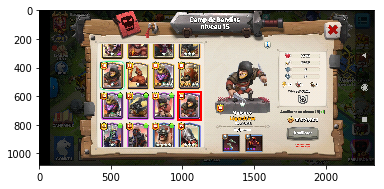

In [13]:
display_result = numpy.uint8(screen_camp)
cv2.rectangle(display_result, 
              (maxLoc[0], maxLoc[1] - t_offset), 
              (maxLoc[0] + t_width, maxLoc[1] - t_offset + t_height), 
              (255, 0, 0), 
              10,
             )
plt.imshow(display_result)

#### Test if we can locate all other cards

In [14]:
def locate_all(matchTemplate_results, threshold, t_width, t_height, t_offset, background: PIL.Image, result_limit = 200000):
    results = numpy.where(matchTemplate_results >= threshold)

    assert len(results[0]) < result_limit, "Too many results"
    print("match found =",len(results[0]))
    
    # Display all match
    display_result = numpy.uint8(background)
    for pt in zip(*results[::-1]):  # Switch collumns and rows
        cv2.rectangle(display_result, 
                  (pt[0], pt[1] - t_offset), 
                  (pt[0] + t_width, pt[1] - t_offset + t_height), 
                  (255, 0, 0), 5)
    f = plt.figure()
    plt.imshow(display_result)

match found = 36


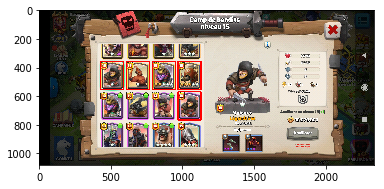

In [15]:
locate_all(border_match, THRESHOLD, t_width, t_height, t_offset, screen_camp)

In theory this works, but we easily have false positive so it's not really practical.

# Second attempt

Using the same process but with 4 larger templates, one for each card color.

## Load the colored templates

In [16]:
RARITIES = ('rare', 'epic', 'legendary')
bandit_borders = {
    rarity: PIL.Image.open("../img/cards/bandit_{}_border.png".format(rarity))
    for rarity in RARITIES
}

match found = 0
match found = 12
match found = 11


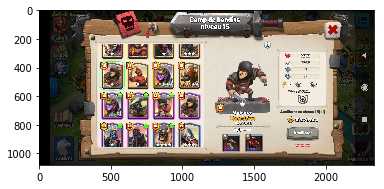

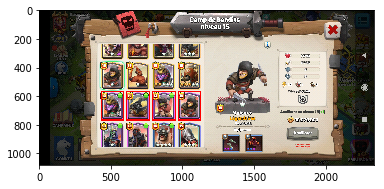

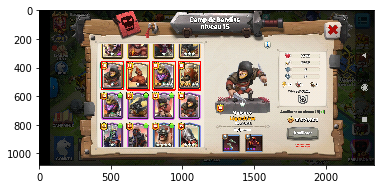

In [17]:
for rarity in RARITIES:
    target, template, mask, t_width, t_height, t_offset = preprocess(screen_camp, bandit_borders[rarity])
    border_match = cv2.matchTemplate(target, template, MATCHING_METHOD, mask=mask)
    locate_all(border_match, THRESHOLD, t_width, t_height, t_offset, screen_camp)

Now we get very good results

- Without cropping we have almost perfect matches (on images entirely on screen)
- with cropping we don't detect every partial cards, and we have many dupplicates of the same cards, but I think we can easily have better results by applying a 2 step cropping (cropping only the top of the card template, to match the top image and cropping only the bottom for the others).

## Test on another image

match found = 6
match found = 17
match found = 0


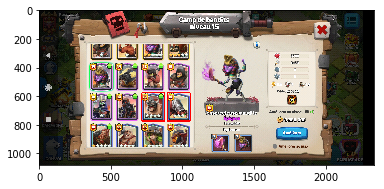

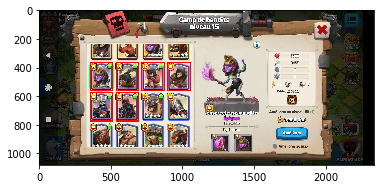

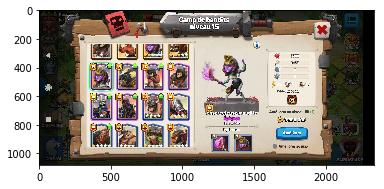

In [18]:
for rarity in RARITIES:
    target, template, mask, t_width, t_height, t_offset = preprocess(screen_camp_2, bandit_borders[rarity])
    border_match = cv2.matchTemplate(target, template, MATCHING_METHOD, mask=mask)
    locate_all(border_match, THRESHOLD, t_width, t_height, t_offset, screen_camp_2)

# Loop the process to locate card on other image with different resolutions

In [19]:
def preprocess2(target: PIL.Image, template: PIL.Image, target_reduction_ratio: float):
    template = template.copy()
    if PREPROCESS_DO_CROP:
        # remove top and bottom of the template
        template_width, template_height = template.size
        template_vertical_crop_offset = PREPROCESS_CROP_SIZE
        template = template.crop((0, PREPROCESS_CROP_SIZE, width, height - PREPROCESS_CROP_SIZE))
    else:
        template_width, template_height = template.size
        template_vertical_crop_offset = 0
    
    # extract the alpha canal of the template and convert everything to numpy array compatible with opencv
    template, mask = extract_mask(template)
    # Resize the image
    target = target.copy()
    new_size = (int(dim*target_reduction_ratio) for dim in target.size[:2])
    target = target.resize(new_size, PIL.Image.BICUBIC)
    target = numpy.uint8(target)
    #print("new target size", new_size, ", template size", (template_width, template_height), template.shape)
    #plt.imshow(target)
    
    ### Optionaly convert to grayscale and apply edge detection
    # Usually this improve result, but here as our image is very thin, this is not sure so I made it optional.
    if PREPROCESS_TO_GRAY:
        template = cv2.cvtColor(template, cv2.COLOR_RGB2GRAY)
        target = cv2.cvtColor(image_to_analyse, cv2.COLOR_RGB2GRAY)
        mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    
    if PREPROCESS_EDGE_DETECTION:
        template = cv2.Canny(template, 50, 200)
        target = cv2.Canny(target, 50, 200)
    
    return target, template, mask, template_width, template_height, template_vertical_crop_offset

In [20]:
def locate_all2(matchTemplate_results, threshold, t_width, t_height, t_offset, background: PIL.Image, scale, result_limit = 20000):
    results = numpy.where(matchTemplate_results >= threshold)

    #assert len(results[0]) < result_limit, "Too many results"
    print("match found =",len(results[0]))
    
    # Display all match
    display_result = numpy.uint8(background)
    for pt in zip(*results[::-1]):  # Switch collumns and rows
        cv2.rectangle(display_result, 
                  (int(pt[0]/scale), int((pt[1] - t_offset)/scale)), 
                  (int((pt[0] + t_width)/scale), int((pt[1] - t_offset + t_height)/scale)), 
                  (255, 0, 0), 5)
    f = plt.figure()
    plt.imshow(display_result)

In [21]:
def find_best_scale(target: PIL.Image, template: PIL.Image, verbose=False):
    #print(target.size, template.size)
    #print(template.size[0] / target.size[0], template.size[1] / target.size[1])
    min_scale = max(template.size[0] / target.size[0], template.size[1] / target.size[1])
    matches = []
    matches_results = []
    scales = numpy.linspace(max(0.2, min_scale * 1.05), 2.0, 19)[::-1] 
    if all(scales != 1.0):
        # ensure 1.0 is in the range
        scales = numpy.append(scales, 1.0)
    for scale in scales:
        if verbose:
            print("testing scale x{} ...".format(scale))
        scaled_target, scaled_template, scaled_mask, t_width, t_height, t_offset = preprocess2(target, template, scale)
        #print(target.shape, template.shape, MATCHING_METHOD, mask.shape)
        
        scale_match = cv2.matchTemplate(scaled_target, scaled_template, MATCHING_METHOD, mask=scaled_mask)
        matches.append(cv2.minMaxLoc(scale_match)[1])
        #matches.append(len(numpy.where(scale_match>=THRESHOLD)[0]))
        #print(matches)
        matches_results.append(scale_match)
    
    if verbose:
        plt.bar(scales, matches)

    #if max(matches) > THRESHOLD:
    #    return scales[matches.index(max(matches))]
    #else:
    #    # No match found in the image
    #    return None
    best_index = matches.index(max(matches))
    return max(matches), scales[best_index], matches_results[best_index]

In [22]:
best_score_camp, best_scale_camp, match_results_camp = find_best_scale(screen_camp, bandit_borders['epic'], verbose=False)
best_scale_camp

1.0

match found = 12


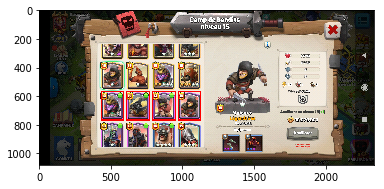

In [23]:
locate_all2(match_results_camp, THRESHOLD*best_score_camp, t_width, t_height, t_offset, screen_camp, best_scale_camp)

In [24]:
best_score_fight, best_scale_fight, match_results_fight = find_best_scale(screen_fight, bandit_borders['legendary'], verbose=False)
best_scale_fight

1.2

match found = 80


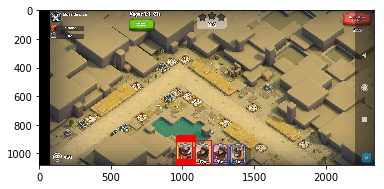

In [30]:
locate_all2(match_results_fight, 0.97*best_score_fight, t_width, t_height, t_offset, screen_fight, best_scale_fight)

## Conclusion: 

This is not perfect, but the process show some results.

It's not really fast especially when searching the right scale, but this step can be done once on a device then reuse many times.

There is still lots of work to use this in practice:
    - better masks
    - better handling of images that overlap the card border : unit level, stars, upgarde icon, quantity, etc
    - remove dupplicates and automatically evaluate the good threshold to use
    - optimize and clean the whole process
    
Now that we can locate cards, it should be easier to develop a process to analyse the data on the card: which unit, which level, which how many stars, and quantity. (for example by using the same template matching for identifying fixed images, and OCR for text)